In [1]:
%load_ext autoreload
%autoreload 2

In [438]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import conf
import utils
from sklearn import metrics
from dataclasses import dataclass
import retrying

In [529]:
WEEKLY_PARAMS_IN = {
    'order': (2, 1, 2),
    'seasonal_order': (2, 0, 2, 7),
    'freq': 'D' , 
#     'initialization': 'approximate_diffuse'
    }
MONTHLY_PARAMS_IN = {
    'order': (0, 0, 0),
    'seasonal_order': (3, 0, 0, 30),
    'freq': 'D',
#     'initialization': 'approximate_diffuse'
    }

In [530]:
WEEKLY_PARAMS_OUT = {
    'order': (2, 0, 2),
    'seasonal_order': (2, 0, 2, 7),
    'freq': 'D' , 
#     'initialization': 'approximate_diffuse'
    }
MONTHLY_PARAMS_OUT = {
    'order': (0, 0, 0),
    'seasonal_order': (3, 1, 0, 30),
    'freq': 'D',
#     'initialization': 'approximate_diffuse'
    }

In [531]:
df = pd.read_csv(conf.DATASET_FILLED)
df = utils.get_dt_info(df)
df = df.set_index('Date')

In [532]:
train = df.loc[:'2019-02-28']
test = df.loc['2019-03-01':]

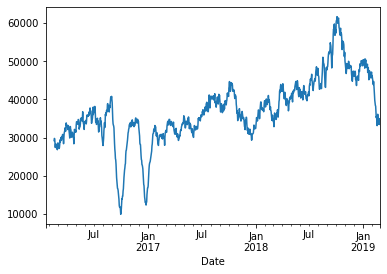

In [533]:
train['CashIn'].rolling(30).mean().plot()

In [534]:
@dataclass
class CascadeSARIMAX:
    weekly_params: dict
    monthly_params: dict
    
    @retrying.retry(stop_max_attempt_number=7, retry_on_exception=lambda x: isinstance(x, np.linalg.LinAlgError))
    def fit(self, series: pd.Series):
        """Fit cascade weekly and monthly SARIMAX models to series.
        
        Arguments:
        series: pd.Series with datetime index.
        
        Returns:
        self: CascadeSARIMAX object
        """
        self.weekly_model = sm.tsa.SARIMAX(series, **self.weekly_params).fit()
        self.monthly_model = sm.tsa.SARIMAX(self.weekly_model.resid, **self.monthly_params).fit()
        return self
    
    @property
    def resid(self):
        """Residuals of the fitted model."""
        return self.monthly_model.resid
    
    @retrying.retry(stop_max_attempt_number=7, retry_on_exception=lambda x: isinstance(x, np.linalg.LinAlgError))
    def predict(self, **kwargs):
        """Make predictions.
        
        Arguments:
        **kwargs: statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper keyword arhuments.
            - start: index or datetime
            - end: index or datetime
            
        Returns:
        forecast: pd.Series
        """
        weekly_forecast = self.weekly_model.predict(**kwargs)
        monthly_forecast = self.monthly_model.predict(**kwargs)
        return  weekly_forecast + monthly_forecast

In [535]:
model = CascadeSARIMAX(WEEKLY_PARAMS_OUT, MONTHLY_PARAMS_OUT)
model

CascadeSARIMAX(weekly_params={'order': (2, 0, 2), 'seasonal_order': (2, 0, 2, 7), 'freq': 'D'}, monthly_params={'order': (0, 0, 0), 'seasonal_order': (3, 1, 0, 30), 'freq': 'D'})

In [536]:
model.fit(train['CashOut'])

CascadeSARIMAX(weekly_params={'order': (2, 0, 2), 'seasonal_order': (2, 0, 2, 7), 'freq': 'D'}, monthly_params={'order': (0, 0, 0), 'seasonal_order': (3, 1, 0, 30), 'freq': 'D'})

In [538]:
model.monthly_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:                        y   No. Observations:                 1137
Model:             SARIMAX(3, 1, 0, 30)   Log Likelihood              -12286.177
Date:                  Sun, 27 Dec 2020   AIC                          24580.354
Time:                          04:02:23   BIC                          24600.392
Sample:                      01-19-2016   HQIC                         24587.932
                           - 02-28-2019                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L30      -0.7101      0.026    -27.414      0.000      -0.761      -0.659
ar.S.L60      -0.4854      0.033    -14.905      0.000      -0.549      -0.422
ar.S.L90      -0.2135      0.028     -7.722      0.000      -0.268      -0.159
sigma2      2.649e+08   1.73e-11   1.53e+19      0.000    2.65e+08    2.65e+08
===================================================================================
Ljung-Box (Q):                       62.35   Jarque-Bera (JB):               115.15
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.24e+34. Standard errors may be unstable.
"""

In [541]:
model_in = CascadeSARIMAX(WEEKLY_PARAMS_IN, MONTHLY_PARAMS_IN)
model_in

CascadeSARIMAX(weekly_params={'order': (2, 1, 2), 'seasonal_order': (2, 0, 2, 7), 'freq': 'D'}, monthly_params={'order': (0, 0, 0), 'seasonal_order': (3, 0, 0, 30), 'freq': 'D'})

In [542]:
model_in.fit(train['CashIn'])

CascadeSARIMAX(weekly_params={'order': (2, 1, 2), 'seasonal_order': (2, 0, 2, 7), 'freq': 'D'}, monthly_params={'order': (0, 0, 0), 'seasonal_order': (3, 0, 0, 30), 'freq': 'D'})

In [550]:
PREDICT_PARAMS = dict(start='2019-03-01', end='2019-03-31')

In [543]:
fig, ax = plt.subplots(2, 1, figsize=(16,6))

test['CashIn'].plot(label='actual', ax=ax[0])
model_in.predict(start='2019-03-01', end='2019-03-31').plot(label='predicted', ax=ax[0])
ax[0].set_title('Cash In Predictions')
ax[0].legend()

test['CashOut'].plot(label='actual', ax=ax[1])
model.predict(start='2019-03-01', end='2019-03-31').plot(label='predicted', ax=ax[1])
ax[1].set_title('Cash Out Predictions');

In [574]:
metrics.mean_absolute_error(test['CashOut'].iloc[:-1], pd.read_csv('predictions.csv')['CashOut'])

9124.766873457096

In [575]:
metrics.mean_absolute_error(test['CashIn'].iloc[:-1], pd.read_csv('predictions.csv')['CashIn'])

15130.609689244877

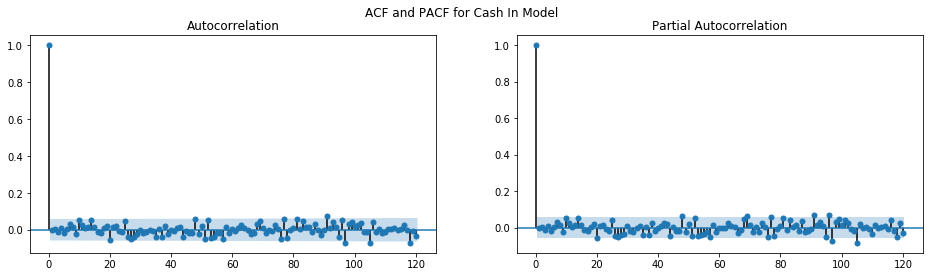

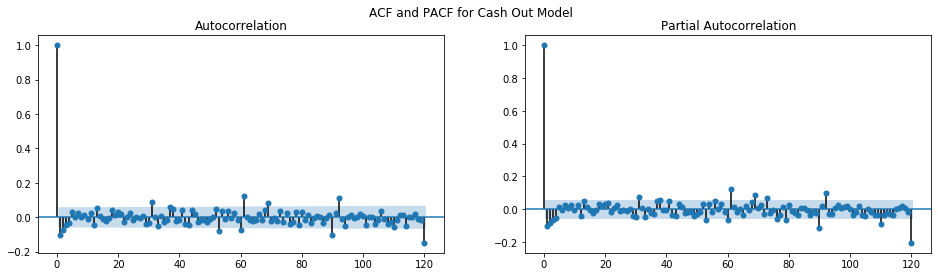

In [544]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sm.graphics.tsa.plot_acf(model_in.resid, lags=120, ax=ax[0]);
sm.graphics.tsa.plot_pacf(model_in.resid, lags=120, ax=ax[1]);
fig.suptitle('ACF and PACF for Cash In Model');

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sm.graphics.tsa.plot_acf(model.resid, lags=120, ax=ax[0]);
sm.graphics.tsa.plot_pacf(model.resid, lags=120, ax=ax[1]);
fig.suptitle('ACF and PACF for Cash Out Model');


ACF and PACF plots indicate that there is no strong correlation between residual lags.

##### Durbin Watson Test [[1]] for autocorrelation between residuals

The test statistic is approximately equal to `2*(1-r)` where ``r`` is the
sample autocorrelation of the residuals. Thus, for `r = 0`, indicating no
serial correlation, the test statistic equals **2**. 

This statistic will
always be between `0` and `4`. The closer to `0` the statistic, the more
evidence for positive serial correlation. The closer to `4`, the more
evidence for negative serial correlation.

[1]: https://www.statsmodels.org/devel/generated/statsmodels.stats.stattools.durbin_watson.html "Durbin-Watson Test"

In [545]:
sm.stats.durbin_watson(model.resid)

2.198543828018243

Durbin-Watson test statistic for `Cash Out` model is close to `2.0`, suggesting that there is no correlation between residuals.

In [546]:
sm.stats.durbin_watson(model_in.resid)

1.9983116544012123

Durbin-Watson test statistic for `Cash In` model is close to `2.0`, suggesting that there is no correlation between residuals.

##### Jarque-Bera Test [[2]] for distribution of residuals


[2]: https://www.statsmodels.org/devel/generated/statsmodels.stats.stattools.jarque_bera.html "Jarque-Bera Test"

In [547]:
print("Test statistic:{}\nP-value:{}\nSkew:{}\nKurtosis:{}".format(*sm.stats.jarque_bera(model_in.resid)))

Test statistic:57.72867551680871
P-value:2.9132475355284744e-13
Skew:0.4532476028638967
Kurtosis:3.629931490285148


In [548]:
print("Test statistic:{}\nP-value:{}\nSkew:{}\nKurtosis:{}".format(*sm.stats.jarque_bera(model.resid)))

Test statistic:118.0382335681707
P-value:2.3351955472497277e-26
Skew:0.3266528790421088
Kurtosis:4.436928599122016


In [549]:
fig, ax = plt.subplots(2, 1, figsize=(16,8), sharex=True)
sns.distplot(model.resid, ax=ax[0])
ax[0].set_title('Distribution of residuals for Cash Out model')
ax[0]

sns.distplot(model_in.resid, ax=ax[1])
ax[1].set_title('Distribution of residuals for Cash Out model');


In [553]:
(model.predict(**PREDICT_PARAMS) - test['CashOut']).median()

-2273.7250796881854

### Mean Absolute Error:

In [576]:
metrics.mean_absolute_error(test['CashOut'], model.predict(start='2019-03-01', end='2019-03-31'))

9873.113014841063

In [577]:
metrics.mean_absolute_error(test['CashIn'], model_in.predict(start='2019-03-01', end='2019-03-31'))

14683.57367419281

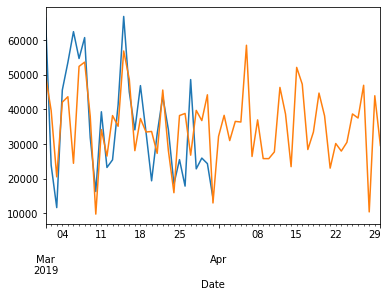

In [570]:
test['CashOut'].plot()
model.predict(start='2019-03-01', end='2019-04-30').plot()

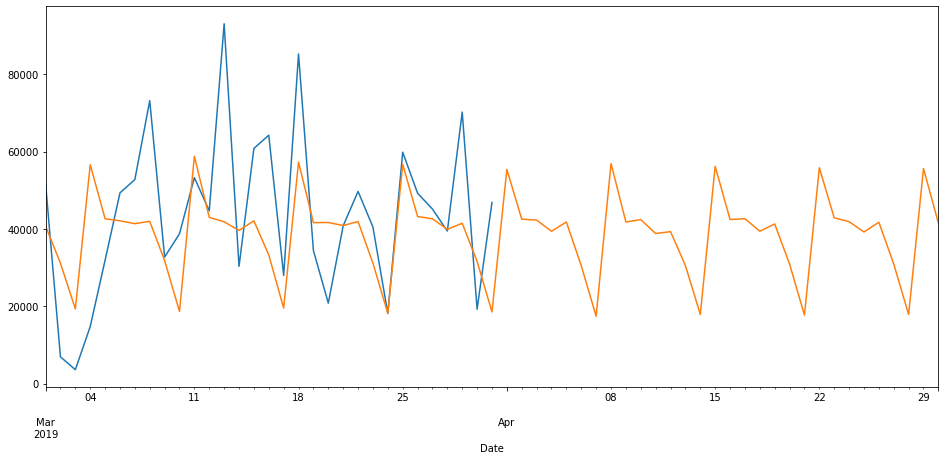

In [572]:
test['CashIn'].plot(figsize=(16,7))
model_in.predict(start='2019-03-01', end='2019-04-30').plot()

---

## Development Phase and Details

In [289]:
model = sm.tsa.SARIMAX(
    train['CashOut'],
    order=(2,0,2),
    seasonal_order=(2,0,2,7),
    freq='D',
#     dates=train['CashOut'].reset_index(level=1, drop=True).index.values
    ).fit()

In [290]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                           CashOut   No. Observations:                 1137
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood              -12579.519
Date:                           Sun, 27 Dec 2020   AIC                          25177.039
Time:                                   02:28:55   BIC                          25222.364
Sample:                               01-19-2016   HQIC                         25194.158
                                    - 02-28-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4940      0.499      0.990      0.322      -0.484       1.472
ar.L2          0.1666      0.282      0.591      0.555      -0.386       0.719
ma.L1         -0.0890      0.500     -0.178      0.859      -1.069       0.891
ma.L2         -0.1914      0.103     -1.853      0.064      -0.394       0.011
ar.S.L7        0.0408      0.061      0.672      0.502      -0.078       0.160
ar.S.L14       0.9572      0.061     15.810      0.000       0.839       1.076
ma.S.L7        0.0186      0.054      0.341      0.733      -0.088       0.125
ma.S.L14      -0.9328      0.051    -18.351      0.000      -1.032      -0.833
sigma2       3.08e+08   1.38e-09   2.23e+17      0.000    3.08e+08    3.08e+08
===================================================================================
Ljung-Box (Q):                       94.64   Jarque-Bera (JB):               394.54
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                             0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.88e+33. Standard errors may be unstable.
"""

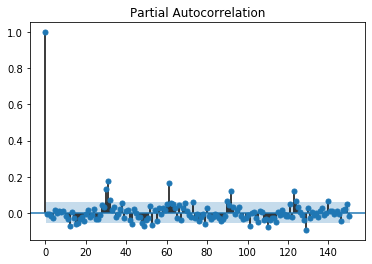

In [291]:
model.resid.pipe(sm.graphics.tsa.plot_pacf, lags=150);

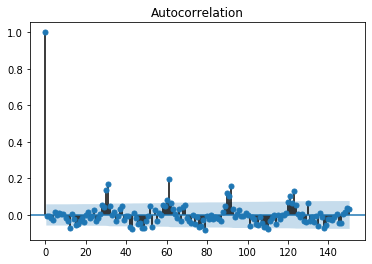

In [292]:
model.resid.pipe(sm.graphics.tsa.plot_acf, lags=150);

In [293]:
resid_model = sm.tsa.SARIMAX(
    model.resid,
    order=(0,0,0),
    seasonal_order=(3,1,0,30)
    ).fit()

c:\users\berk_\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [294]:
resid_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:                        y   No. Observations:                 1137
Model:             SARIMAX(3, 1, 0, 30)   Log Likelihood              -12286.177
Date:                  Sun, 27 Dec 2020   AIC                          24580.354
Time:                          02:29:56   BIC                          24600.392
Sample:                      01-19-2016   HQIC                         24587.932
                           - 02-28-2019                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L30      -0.7101      0.026    -27.414      0.000      -0.761      -0.659
ar.S.L60      -0.4854      0.033    -14.905      0.000      -0.549      -0.422
ar.S.L90      -0.2135      0.028     -7.722      0.000      -0.268      -0.159
sigma2      2.649e+08   1.73e-11   1.53e+19      0.000    2.65e+08    2.65e+08
===================================================================================
Ljung-Box (Q):                       62.35   Jarque-Bera (JB):               115.15
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.24e+34. Standard errors may be unstable.
"""

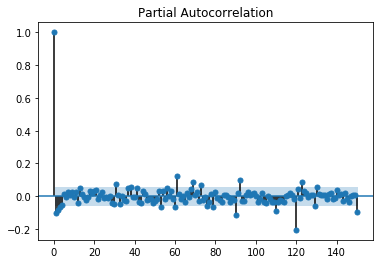

In [295]:
resid_model.resid.pipe(sm.graphics.tsa.plot_pacf, lags=150);

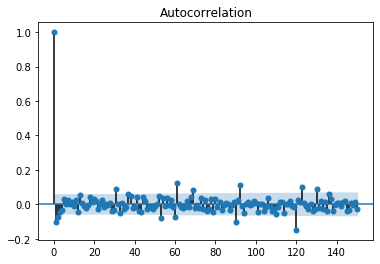

In [296]:
resid_model.resid.pipe(sm.graphics.tsa.plot_acf, lags=150);

In [297]:
y_pred = model.predict(start='2019-03-01', end='2019-03-31') + resid_model.predict(start='2019-03-01', end='2019-03-31')

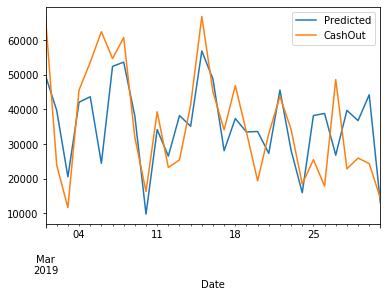

In [298]:
y_pred.loc['2019-03-01':].plot(label='Predicted')
test['CashOut'].plot()
plt.legend()

In [299]:
metrics.r2_score(test['CashOut'], y_pred)

0.362073320765563